## Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os, sys,  signal, time
import subprocess
from tqdm import tqdm

In [2]:
%matplotlib inline
sns.set(style="ticks", color_codes=True)

## Performance Counters

Performance counters are special hardware registers available on most modern CPUs. These registers count the number of certain types of hw events: such as instructions executed, cachemisses suffered, or branches mis-predicted - without slowing down the kernel or applications. These registers can also trigger interrupts when a threshold number of events have passed - and can thus be used to profile the code that runs on that CPU.


## Reading Performance counters

### rdmsr: 
Reads the contents of a 64-bit model specific register (MSR) specified in the ECX register into registers EDX:EAX. This instruction must be executed at privilege level 0 or in real-address mode

### rdpmc
Is slightly faster that the equivelent rdmsr instruction.  rdpmc can
also be configured to allow access to the counters from userspace, without
being priviledged.


### From userspace (Linux)
The Linux Performance Counter subsystem provides an abstraction of these hardware capabilities. It provides per task and per CPU counters, counter groups, and it provides event capabilities on top of those.  It provides "virtual" 64-bit counters, regardless of the width of the
underlying hardware counters. Performance counters are accessed via special file descriptors. There's one file descriptor per virtual counter used. The special file descriptor is opened via the perf_event_open() system call. These system call do not use rdpmc but rdpmc is not necessarily faster than other methods for reading event values.

TODO: libpfm

### Minimal example perf_event_open
```c++
#include <iostream>

#include <linux/perf_event.h>
#include <asm/unistd.h>
#include <sys/ioctl.h>
#include <memory.h> 
#include <unistd.h>

using namespace std;

int main(int argc, char **argv)
{
   long long count;
   int fd;
   
   // Configure the event to open
   struct perf_event_attr pe;
   memset(&pe, 0, sizeof(struct perf_event_attr));
   pe.type = PERF_TYPE_HARDWARE;
   pe.size = sizeof(struct perf_event_attr);
   pe.config = PERF_COUNT_HW_INSTRUCTIONS;
   
   // Call perf_event_open and create the fd
   if ((fd = syscall(__NR_perf_event_open, &pe, 0, -1, -1, 0)) == -1)
      return -1;
    
   // Reset the counter and enable
   ioctl(fd, PERF_EVENT_IOC_RESET, 0);
   ioctl(fd, PERF_EVENT_IOC_ENABLE, 0);

   cout << "Measuring instruction count for this cout" << endl;

   ioctl(fd, PERF_EVENT_IOC_DISABLE, 0);
   read(fd, &count, sizeof(long long));

   cout << "Used " << count << " instructions" << endl;
}
```

## API comparation

There are only a few APIs that allow access to these counters, and many of them are poorly documented, unstable, or unavailable. In addition, performance metrics may have different definitions and different programming interfaces on different platforms.
    
 * Linux perf (http://man7.org/linux/man-pages/man2/perf_event_open.2.html)
 * ***pfmon c (http://perfmon2.sourceforge.net/man/pfmon.html)
 * ***pfmon python (http://perfmon2.sourceforge.net/man/pfmon.html)
 * PAPI c (https://icl.cs.utk.edu/projects/papi/wiki/Main_Page)
 * PAPI python (https://flozz.github.io/pypapi/install.html)
 * ***pmu-tools (https://github.com/andikleen/pmu-tools)



## Benchmarks

#### Precise instructions number
```assembly
section .data
    msg db      "hello, world!"

section .text
    global _start
_start:
    push    rbp 
    mov     rbp, rsp 
    mov     DWORD[rbp-0x4], 0x0

    loop:
    mov     rax, 1
    mov     rdi, 1
    mov     rsi, msg 
    mov     rdx, 13
    syscall
    add     DWORD[rbp-0x4], 1
    cmp     DWORD[rbp-0x4], 100000
    jne     loop
    
    pop rbp
    mov    rax, 60
    mov    rdi, 0
    syscall

; 3 + 8*1000 + 4 = 8007 instructions
```
Mounted with:
```bash
nasm -f elf64 hello.asm -o hello.o && ld hello.o -o hello
```

#### Simple large loop with linking
```c++
#include <iostream>
#include <math.h>

using namespace std;

int main()
{
    double x= 0;
    for(int i=1; i<99999; i++)
    {
        for(int j=1; j<99; j++)
        {
            x=pow(i,j)+sqrt(j)*sqrt(j);
        }   
    }
    return x;
}
```

Compiled with:
```bash
g++ simple_loop.cpp -o simple_dynamic_ld
g++ -static simple_loop.cpp -o simple_static_ld
```

## Measuring for 100 executions:
   * TOTAL INSTRUCTIONS
   * BRANCH INSTRUCTIONS
   * BRANCH MISPREDICT
   * TOTAL CACHE READ L3

In [65]:
np.set_printoptions(formatter={'float': '{: 0.5f}'.format})
def run_python(pname):
    #pip install python_papi
    print("python-papi",pname)
    from pypapi import papi_low as papi
    from pypapi import events

    papi.library_init()
    total=[]
    cont= 0

    for i in range(100):
        try:
            evs= papi.create_eventset()
            papi.add_event(evs, events.PAPI_TOT_INS)
            papi.add_event(evs, events.PAPI_BR_INS)
            papi.add_event(evs, events.PAPI_BR_MSP)
            papi.add_event(evs, events.PAPI_L3_TCR)

            p= subprocess.Popen([pname], stdout= subprocess.PIPE)
            os.kill(p.pid, signal.SIGSTOP)
            papi.attach(evs, p.pid)
            papi.start(evs)
            os.kill(p.pid, signal.SIGCONT)
            p.wait()
            result= papi.stop(evs)
            total.append(result)
            papi.cleanup_eventset(evs)
            papi.destroy_eventset(evs)
            sys.stdout.write('.')
            sys.stdout.flush()
            cont+=1
            # print(result)
        except Exception as e:
            print("Error on", cont)
            print(e)
            pass

    total= np.asarray(total)
    print()
    print('Mean',total.mean(axis=0))
    print('Std',total.std(axis=0))
    return total.mean(axis=0), total.std(axis=0)


def run_all(bench, prog):
    m= []
    print(bench, prog)
    for i in range(100):
        sys.stdout.write('.')
        sys.stdout.flush()
        data= subprocess.Popen([bench,prog],stdout=subprocess.PIPE).stdout.readlines()
        n= []
        names= []
        for c in data:
            aux= str(c)
            names.append(str(aux.split(':')[0]))
            n.append(int(str(aux.split(':')[1])[:-3]))
        m.append(n)
    df= pd.DataFrame(m, columns=names)
    print()
    print('Mean', df.mean().values)
    print('Std', df.std().values)
    return df.mean().values, df.std().values

In [64]:
df= []
for p in ['hello','simple_static_ld','simple_dynamic_ld']:
    print('')
    print('')
    print("Program",p)
    if p  != 'hello': # too fast
        papi_python_mean, papi_python_std= run_python('./benchmarks/'+p)
    else: papi_python_mean, papi_python_std= None,None
    linux_perf_mean, linux_perf_std= run_all('./api_tests/linux_perf', 'benchmarks/'+p)
    papi_perf_mean, papi_perf_std= run_all('./api_tests/papi_perf', 'benchmarks/'+p)
    df.append([papi_python_mean, papi_python_std, linux_perf_mean, linux_perf_std, papi_perf_mean, papi_perf_std])
df= pd.DataFrame(df,columns=['papi_python_mean', 'papi_python_std', 'linux_perf_mean', 
                             'linux_perf_std', 'papi_perf_mean', 'papi_perf_std'])



Program hello
./api_tests/linux_perf benchmarks/hello
....................................................................................................
[ 800053.10000  200015.32000  4.28000  37.43000]
[ 102.76987  23.65616  7.57465  46.58895]
./api_tests/papi_perf benchmarks/hello
....................................................................................................
[ 800012.15000  200006.15000  1.48000  61.53000]
[ 2.43450  2.43450  1.67260  79.54002]


Program simple_static_ld
....................................................................................................
[ 3208825194.36000  547062717.35000  302093.02000  8524.68000]
[ 113474.58217  19951.05635  8226.58315  8123.22302]
./api_tests/linux_perf benchmarks/simple_static_ld
....................................................................................................
[ 3208969026.02000  547095163.58000  301272.83000  4716.76000]
[ 108.92987  65.48671  1971.18889  3574.15419]
./api_tests/papi_p

In [58]:
df['papi_python_mean'][0]= [0,0,0,0]
df['papi_python_std'][0]= [0,0,0,0]
display( np.array((df['linux_perf_mean']-df['papi_perf_mean'])/df['linux_perf_mean']*100) )
display( np.array((df['linux_perf_mean']-df['papi_python_mean'])/df['linux_perf_mean']*100) )
display( np.array((df['papi_perf_mean']-df['papi_python_mean'])/df['linux_perf_mean']*100) )
#df

array([array([ 0.00136,  0.00118,  30.20833, -81.12392]),
       array([-0.00000, -0.00000, -0.06471, -39.12552]),
       array([ 0.00000,  0.00000, -0.12363, -32.12942])], dtype=object)

array([array([ 100.00000,  100.00000,  100.00000,  100.00000]),
       array([ 0.00417,  0.00572,  0.13544, -35.99606]),
       array([ 0.00391,  0.00461,  0.25289, -5.06716])], dtype=object)

array([array([ 99.99864,  99.99882,  69.79167,  181.12392]),
       array([ 0.00417,  0.00572,  0.20015,  3.12946]),
       array([ 0.00391,  0.00461,  0.37651,  27.06226])], dtype=object)

## Results

|     API     | Sync start | Attach to pid | Variance | Overhead | Sampling method                   | Control |
|:-----------:|:----------:|:-------------:|----------|----------|-----------------------------------|---------|
| PAPI python |     no     |      yes      | HIGH     |  MEDIUM  |                Time               |   LOW   |
|    PAPI c   |     yes    |      yes      | LOW      |    LOW   |         Time,interruption         |  MEDIUM |
|  Linux perf |     yes    |      yes      | MEDIUM   |    LOW   |  Time,interruption,wait for event |   HIGH  |

## Sampling methods comparison

### Method interruption:
Each n events a signal is genereted and call the predifined function.
### Method wait:
Wait for the event file descriptor set a flag after n events.
### Time
Sample every n ms

In [61]:
p= subprocess.Popen(['./tests/sample_teste', 'benchmarks/hello'], stdout=subprocess.PIPE)
for l in p.stdout.readlines(): print(str(l))

b'....................................................................................................\n'
b'Sampling method Interruption : 793084 +- 5785.85  nsamples 23.98\n'
b'Sampling method Wait : 662745 +- 9089.77  nsamples 22.19\n'
b'Sampling method Time : 799999 +- 116.394  nsamples 24.06\n'


In [67]:
p= subprocess.Popen(['./tests/sample_teste', 'benchmarks/simple_static_ld'], stdout=subprocess.PIPE)
for l in p.stdout.readlines(): print(str(l))

b'....................................................................................................\n'
b'Sampling method Interruption : 1.60948e+09 +- 8.93522e+08  nsamples 57006.9\n'
b'Sampling method Wait : 6.09667e+06 +- 1.1924e+06  nsamples 21.45\n'
b'Sampling method Time : -1.08752e+09 +- 868992  nsamples 193.74\n'


Sampling over time demonstrate to be the less agressive method

## Tools comparation
    * Perf
    * gprof
    * myprof


TODO

## Sampling counters over time

In [60]:
df = pd.read_csv('hello.csv')
df_pw = pd.read_csv('hello_pw.csv')
df= pd.concat([df,df_pw],axis=1)
display(df.head(10))
print(df.sum())
loss= (800007-df['instructions'].sum())/800007
print("Lost {} instructions of 800007 {:.3f}%".format(800007-df['instructions'].sum(), loss*100))

,time,instructions,cache_ll,branch_instructions,branch_misses,energy-cores,energy-pkg,energy-ram
0,5682210,34391,118,8591,17,1.038220,1.325360,0
1,7318255,10024,29,2506,1,0.375092,0.479645,0
2,10379469,18896,39,4724,3,0.382385,0.487076,0
3,18135255,47978,40,11996,0,0.383011,0.487930,0
4,23399620,32096,61,8024,4,0.388962,0.496048,0
5,28646995,32648,53,8162,2,0.428040,0.545776,0
6,34927599,38065,182,9517,4,0.388779,0.495941,0
7,39910534,31096,35,7774,2,0.385788,0.492584,0
8,48034909,50664,65,12666,0,0.388290,0.494400,0
9,55811639,47616,50,11904,2,0.381805,0.487488,0


time                   1.048117e+09
instructions           8.002530e+05
cache_ll               8.220000e+02
branch_instructions    2.000580e+05
branch_misses          4.000000e+01
energy-cores           7.544355e+00
energy-pkg             9.643796e+00
energy-ram             0.000000e+00
dtype: float64
Lost -246 instructions of 800007 -0.031%


/home/vitor/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


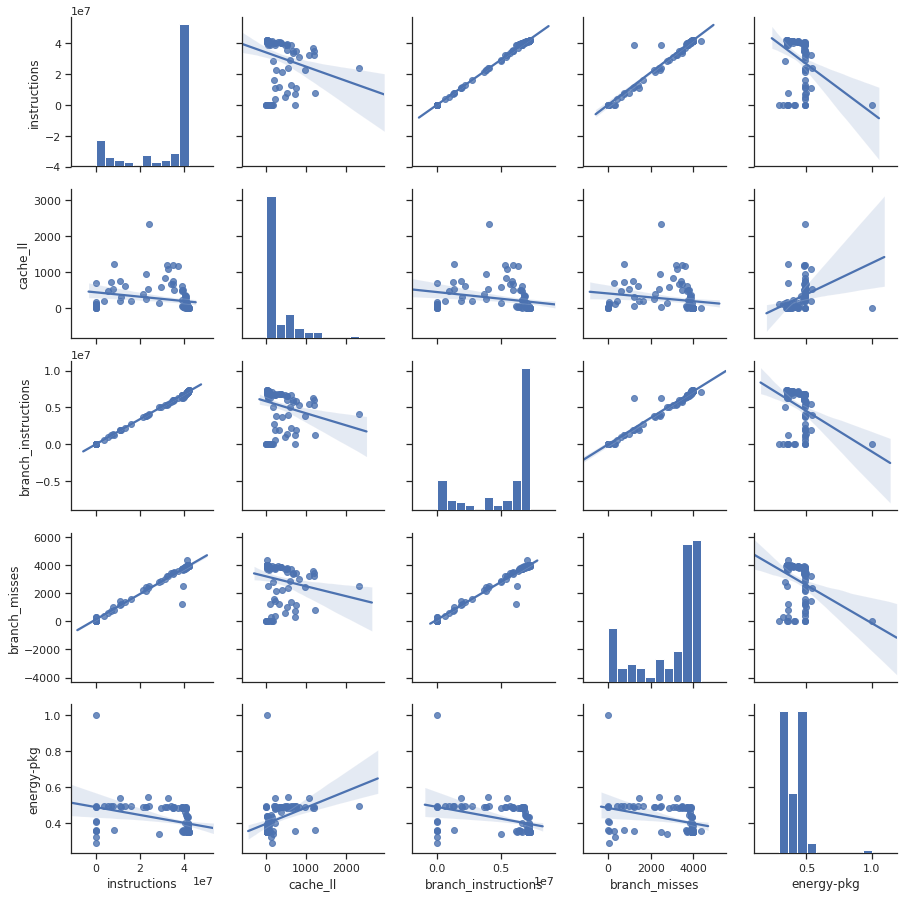

In [51]:
g = sns.pairplot(df, vars=["instructions", "cache_ll", "branch_instructions", "branch_misses", "energy-pkg"], kind="reg")

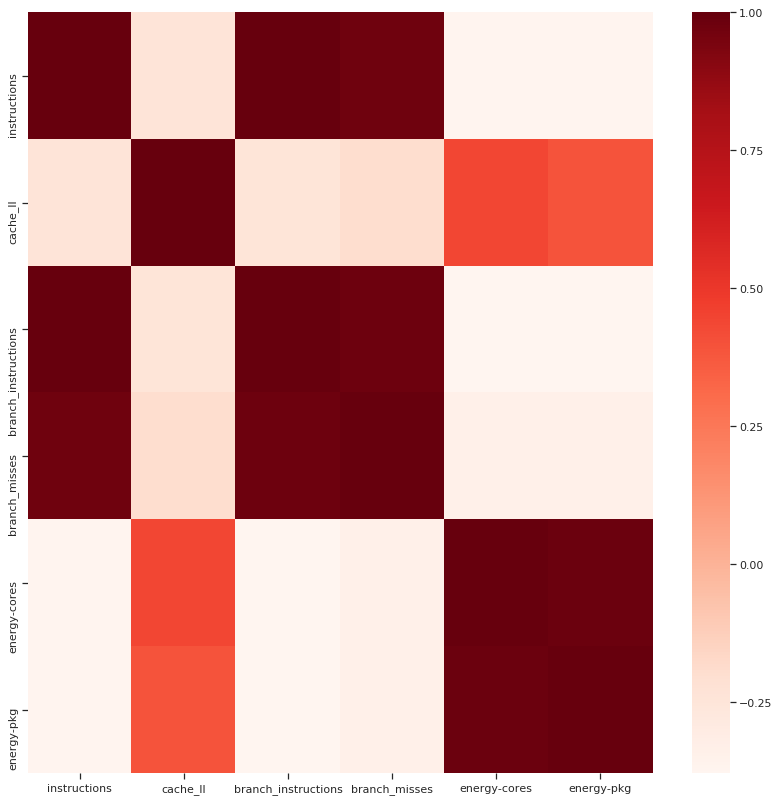

In [52]:
fig, ax= plt.subplots(figsize=(14,14))
s=list(df.columns)
s.remove('time')
s.remove('energy-ram')
corr= df[s].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,ax=ax,cmap='Reds')

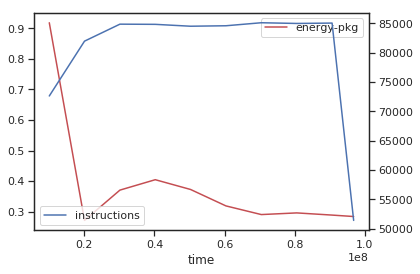

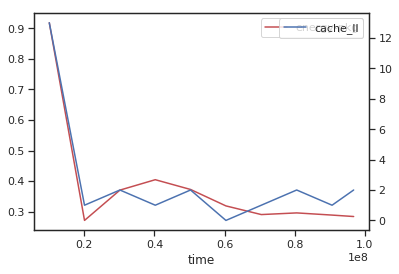

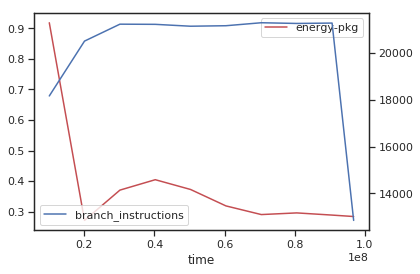

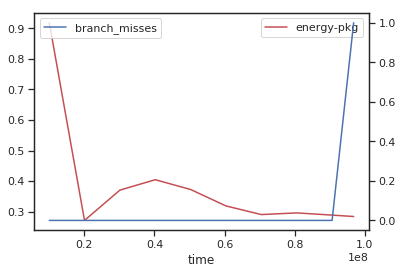

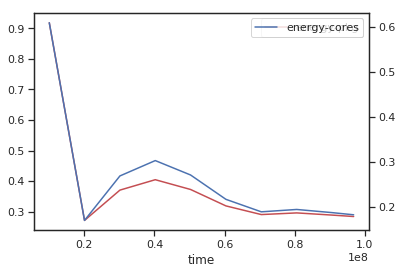

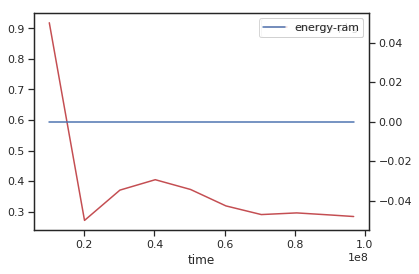

In [90]:
for t in df.columns:
    if t == 'time' or t == 'energy-pkg':
        continue
    fig, ax1 = plt.subplots()
    df.plot(x='time',y='energy-pkg',ax=ax1,c='r')
    ax2= ax1.twinx()
    df.plot(x='time',y=t,ax=ax2)

## Supercomputer

```c++
// Supported pmu models
// ix86arch Intel X86 architectural PMU 7
// perf perf_events generic PMU 105
// perf_raw perf_events raw PMU 1
// hsw_ep Intel Haswell EP 74
// 4 pmus, supported 1279 events
```

In [3]:
dfs= None
for l in tqdm(os.listdir('data/')):
    if l.endswith('csv') and 'pw' not in l:
        pname= l.split('_')[0]
        psize= l.split('_')[1]
        df = pd.read_csv('data/'+l)
        df_pw = pd.read_csv('data/'+l.split('.')[0]+'_pw.csv')
        df= pd.concat([df,df_pw],axis=1)
        df['program']= [pname]*df.shape[0]
        df['input']= [psize]*df.shape[0]
        dfs= pd.concat([dfs,df],axis=0)
        #data= np.hstack([df,df_pw])
        #print(l)
dfs.to_csv('all.csv')

100%|██████████| 300/300 [00:08<00:00, 36.01it/s]


In [22]:
df= dfs[dfs['program']=='lu']
for c in df.columns:
    print(c)
    display(df.groupby('input')[c].describe())

time


,count,mean,std,min,25%,50%,75%,max
input,,,,,,,,
EXTRALARGE,142336.0,7.219695e+11,4.168810e+11,6897579.0,3.609409e+11,7.219818e+11,1.082988e+12,1.443928e+12
LARGE,8266.0,4.189543e+10,2.418687e+10,10035348.0,2.095331e+10,4.189676e+10,6.283766e+10,8.376665e+10
MEDIUM,129.0,6.588966e+08,3.789705e+08,10062615.0,3.344361e+08,6.587578e+08,9.835380e+08,1.296898e+09
MINI,1.0,6.827134e+06,NaN,6827134.0,6.827134e+06,6.827134e+06,6.827134e+06,6.827134e+06
SMALL,5.0,2.870711e+07,1.369139e+07,10045492.0,2.022225e+07,3.035701e+07,4.050449e+07,4.240630e+07


instructions


,count,mean,std,min,25%,50%,75%,max
input,,,,,,,,
EXTRALARGE,142336.0,2.162846e+07,4.814018e+06,0.0,21361981.5,21433237.5,21481288.25,98338871.0
LARGE,8266.0,4.698679e+07,1.103277e+07,0.0,48960416.0,49096982.0,49304373.50,60278456.0
MEDIUM,129.0,3.883109e+07,2.674996e+07,0.0,5981124.0,40326981.0,64977193.00,65254648.0
MINI,1.0,1.034338e+07,NaN,10343385.0,10343385.0,10343385.0,10343385.00,10343385.0
SMALL,5.0,2.810983e+07,2.867366e+07,1707579.0,10373776.0,10412819.0,53924459.00,64130507.0


cache_ll


,count,mean,std,min,25%,50%,75%,max
input,,,,,,,,
EXTRALARGE,142336.0,1.048170e+06,245251.558919,0.0,983941.0,986177.0,1138267.25,6555845.0
LARGE,8266.0,4.603862e+05,165161.389196,0.0,534237.5,539554.5,544446.75,666297.0
MEDIUM,129.0,2.273805e+04,43520.109741,0.0,108.0,7259.0,7955.00,131682.0
MINI,1.0,1.839200e+04,NaN,18392.0,18392.0,18392.0,18392.00,18392.0
SMALL,5.0,4.680000e+03,8488.283366,136.0,161.0,751.0,2594.00,19758.0


branch_instructions


,count,mean,std,min,25%,50%,75%,max
input,,,,,,,,
EXTRALARGE,142336.0,1.237231e+06,2.530291e+05,0.0,1099141.0,1101568.0,1319514.0,7564312.0
LARGE,8266.0,2.746236e+06,6.612841e+05,0.0,2512001.5,2518999.0,2529673.5,4716228.0
MEDIUM,129.0,1.752843e+06,4.822271e+05,0.0,1168867.0,2076548.0,2137271.0,2220161.0
MINI,1.0,1.283750e+06,NaN,1283750.0,1283750.0,1283750.0,1283750.0,1283750.0
SMALL,5.0,2.020961e+06,1.055118e+06,333254.0,2026337.0,2035574.0,2527817.0,3181821.0


branch_misses


,count,mean,std,min,25%,50%,75%,max
input,,,,,,,,
EXTRALARGE,142336.0,600.233047,2689.139911,0.0,137.0,138.0,231.0,27584.0
LARGE,8266.0,2635.487418,5608.982948,0.0,628.0,630.0,634.0,38016.0
MEDIUM,129.0,6964.782946,4784.846105,0.0,2669.0,4821.0,12261.0,16411.0
MINI,1.0,23822.000000,NaN,23822.0,23822.0,23822.0,23822.0,23822.0
SMALL,5.0,18357.200000,7962.847054,4359.0,19751.0,21200.0,23169.0,23307.0


energy-cores


,count,mean,std,min,25%,50%,75%,max
input,,,,,,,,
EXTRALARGE,142336.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LARGE,8266.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MEDIUM,129.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MINI,1.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0
SMALL,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


energy-pkg


,count,mean,std,min,25%,50%,75%,max
input,,,,,,,,
EXTRALARGE,142336.0,0.731747,0.040088,0.658020,0.708191,0.715271,0.743652,2.54590
LARGE,8266.0,0.830787,0.020705,0.733032,0.818726,0.821716,0.850205,1.60651
MEDIUM,129.0,0.782601,0.088139,0.701294,0.714294,0.790039,0.823792,1.54712
MINI,1.0,1.608340,NaN,1.608340,1.608340,1.608340,1.608340,1.60834
SMALL,5.0,0.995654,0.371105,0.802124,0.826843,0.845032,0.845520,1.65875


energy-ram


,count,mean,std,min,25%,50%,75%,max
input,,,,,,,,
EXTRALARGE,142336.0,0.097291,0.004547,0.078155,0.095077,0.097259,0.100082,0.342850
LARGE,8266.0,0.082458,0.004444,0.072678,0.079300,0.081390,0.084534,0.202896
MEDIUM,129.0,0.082315,0.009058,0.073013,0.078705,0.081253,0.084000,0.176468
MINI,1.0,0.172150,NaN,0.172150,0.172150,0.172150,0.172150,0.172150
SMALL,5.0,0.101389,0.043802,0.079300,0.080307,0.083679,0.084000,0.179657


program


,count,unique,top,freq
input,,,,
EXTRALARGE,142336,1,lu,142336
LARGE,8266,1,lu,8266
MEDIUM,129,1,lu,129
MINI,1,1,lu,1
SMALL,5,1,lu,5


input


,count,unique,top,freq
input,,,,
EXTRALARGE,142336,1,EXTRALARGE,142336
LARGE,8266,1,LARGE,8266
MEDIUM,129,1,MEDIUM,129
MINI,1,1,MINI,1
SMALL,5,1,SMALL,5


Data size  SMALL


/home/vitor/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Data size  MEDIUM
Data size  LARGE
Data size  EXTRALARGE
Data size  MINI


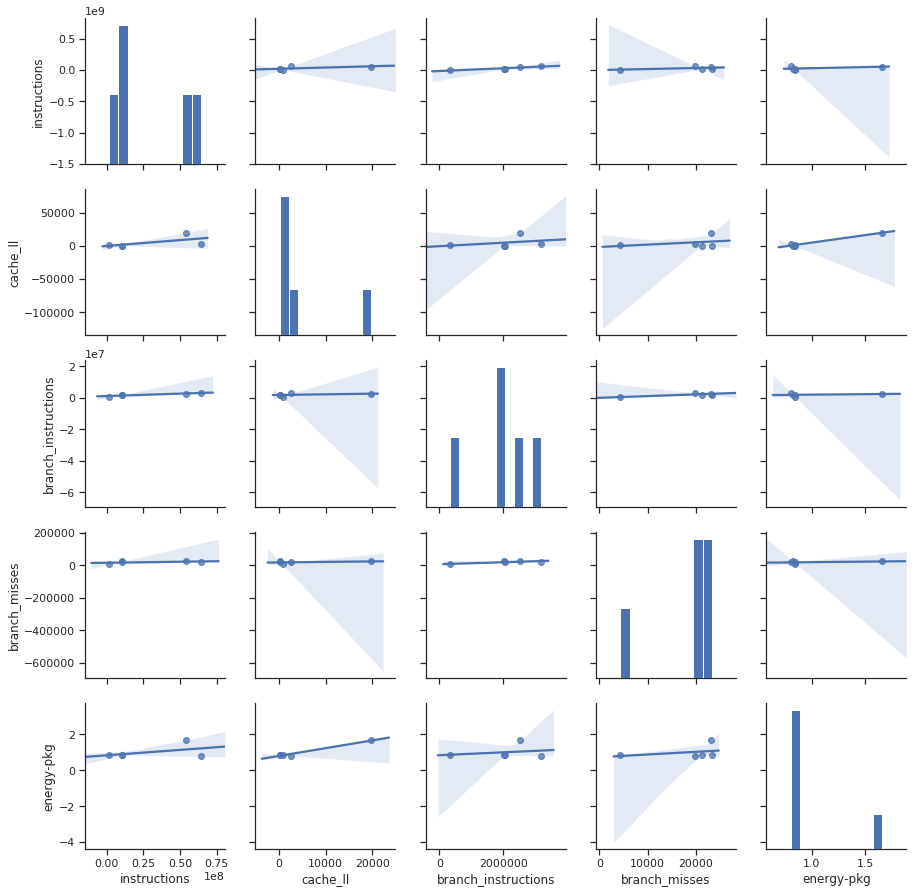

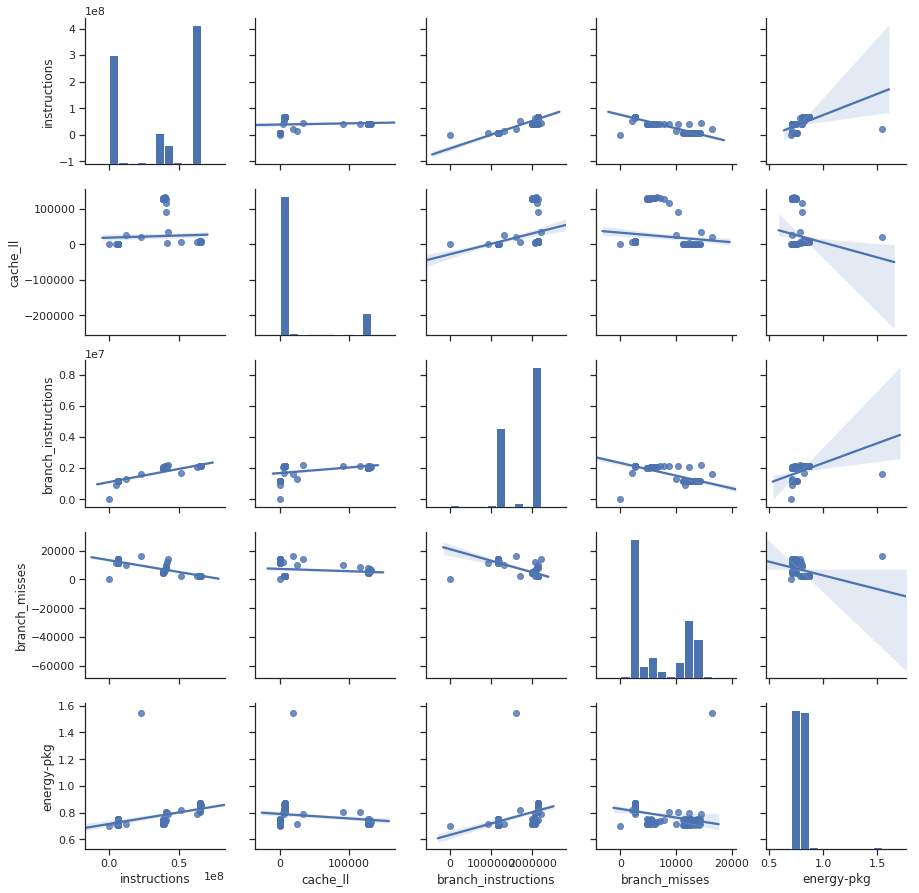

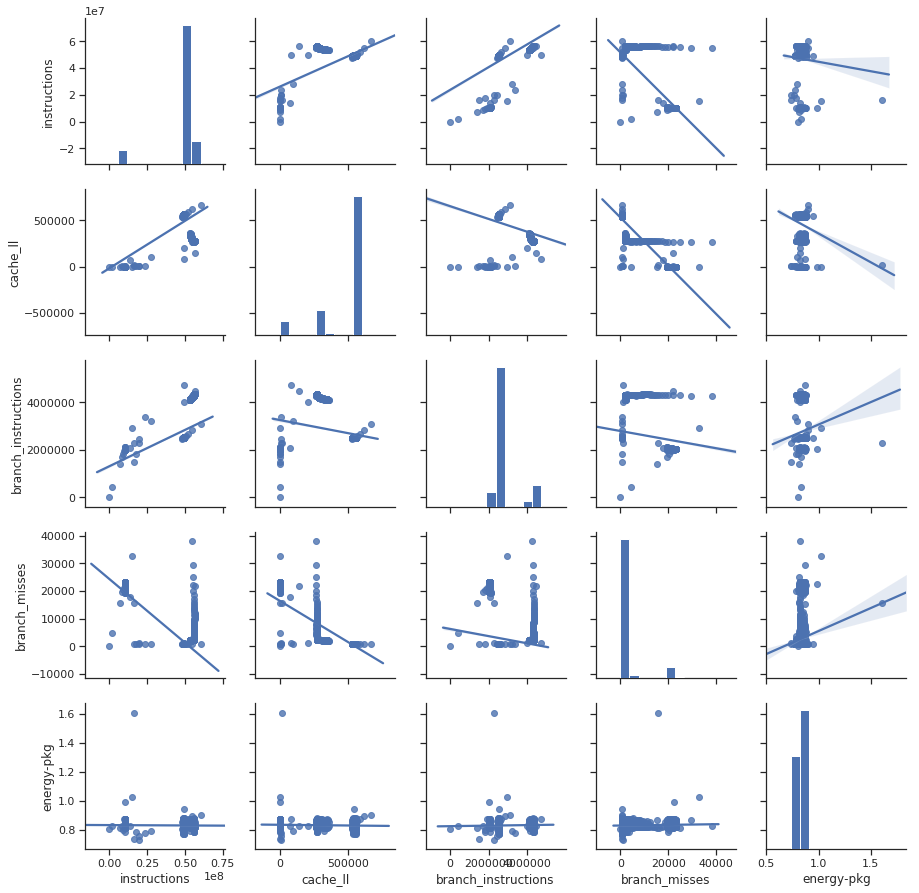

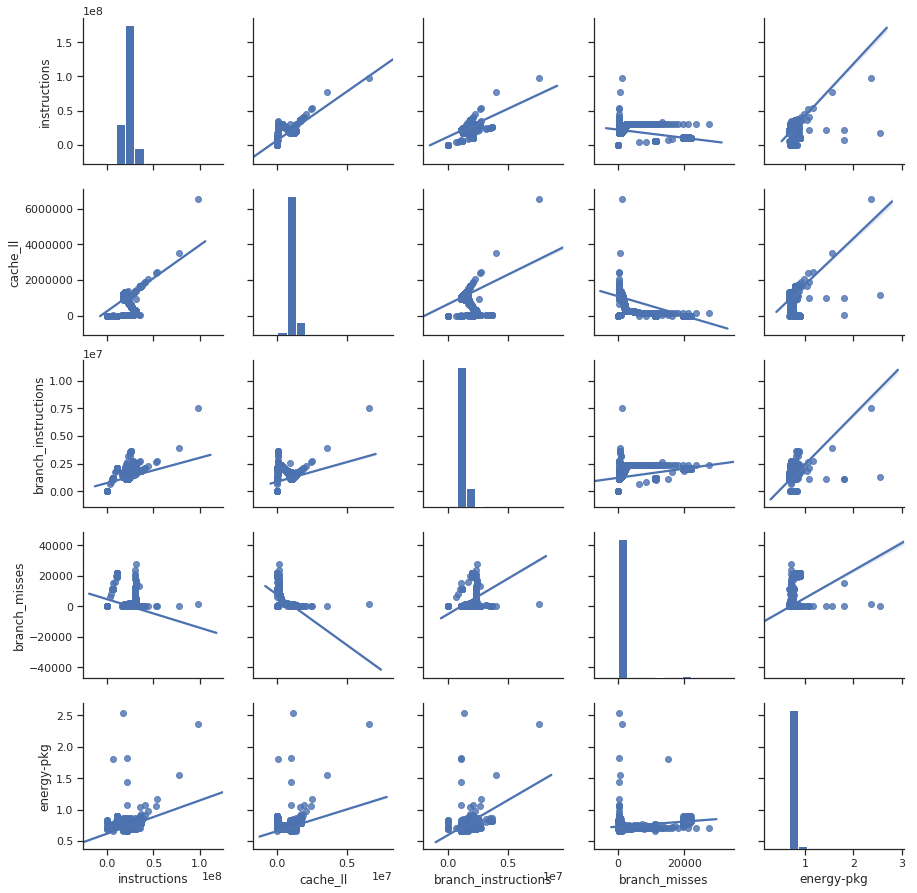

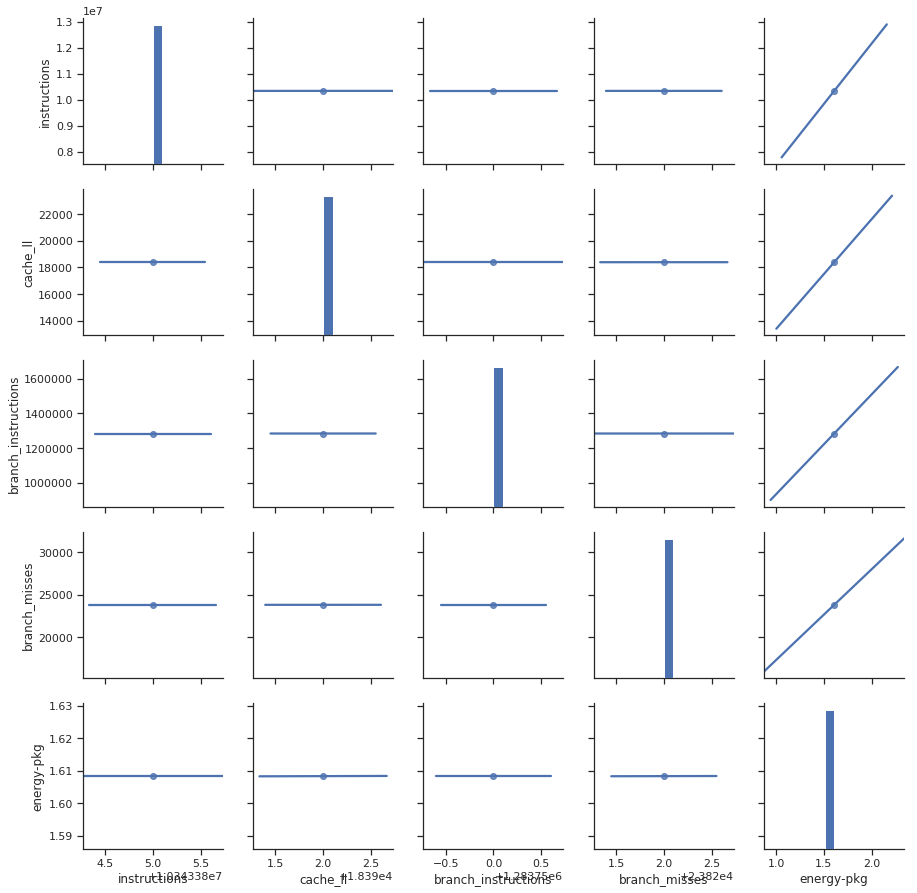

In [5]:
for ins in dfs['input'].unique():
    print("Data size ", ins)
    df= dfs[ (dfs['program']=='lu')&(dfs['input']==ins) ]
    g = sns.pairplot(df, vars=["instructions", "cache_ll", "branch_instructions", "branch_misses", "energy-pkg"], kind="reg")

In [34]:
df= dfs[dfs['program']=='lu']
df['input']= pd.Categorical(df['input']).codes
X=df[['instructions','cache_ll', 'branch_instructions', 'branch_misses']].values
Y=df['input']


/home/vitor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
from sklearn import svm
ml= svm.SVC()
ml.fit(X,Y)

In [ ]:
ml.score(X,Y)